In [18]:
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectFromModel
import numpy as np
import pandas as pd
from pprint import pprint
from os import listdir
from os.path import isfile, join
from sklearn.model_selection import StratifiedKFold
from scipy import stats
import numpy as np
from sklearn import linear_model, svm
import re
from sklearn.metrics import roc_curve, auc,f1_score
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
#s = "../braindata/data_1_mor_select_100.csv"
import os          
from sklearn import linear_model, svm
from sklearn.ensemble import ExtraTreesClassifier
# from IPython.core.interactiveshell import InteractiveShell
# InteractiveShell.ast_node_interactivity = "all"
from sklearn import svm, grid_search
from sklearn.model_selection import GridSearchCV

##read the data and clean data
def data_fetch_clean(file,type):
    #os.getcwd()
    #os.chdir('../braindata')
    dd =pd.read_csv(file,header=0)
    print(dd.shape)
    import csv

    with open(file, 'r') as f:
        d_reader = csv.DictReader(f)

        #get fieldnames from DictReader object and store in list
        headers = d_reader.fieldnames
    data=np.array(dd)
    #print(data.shape)
    idx_IN_columns = np.append(np.array([3,4]),np.array(range(11,data.shape[1])))
    print(idx_IN_columns)
    X=data[:,idx_IN_columns]
    #features=data[:,11:data.shape[1]]
    #features = features.transpose()
    X = stats.zscore(X)
    #print(features.shape)
    y=data[:,type]
    #5: ad-smi / 6:mci-smi / 7:adonly-smi / 8:ad-mci / 9:adonly-mci / 10:adonly - adwithsmallvv


    ind_num=np.isnan(y)
    # print(ind_num.shape)


    y_no_nan = y[~ind_num]

    X_no_nan = X[~ind_num,:]

           # print(y.shape)

    y=y_no_nan
    X=X_no_nan
    feature_num_all=[]
    lr_all_feature=[]
    svm_all_feature=[]
    lr_fls_feature=[]
    svm_fls_feature=[]
    base_labels= []

    np.isnan(X).any()

    X[np.isnan(X)] = np.median(X[~np.isnan(X)])
    return X,y

#classification and cross validation 
def main(X,y,svm_para,lr_para,cv,re,name,n_features):
    logistic = linear_model.LogisticRegression(C=lr_para["C"])
    rbf = svm.SVC(C=svm_para["C"],kernel='linear',gamma=svm_para["gamma"])

    skf=RepeatedStratifiedKFold(n_splits=cv, n_repeats=re)
    lr_all_accs = []
    lr_all_scores = []
    lr_f1s = []
    svm_all_accs = []
    svm_all_scores = []
    svm_f1s = []

    lr_accuracies = []
    lr_scores = []
    svm_accuracies = []
    svm_scores = []
    strat_labels = []


    for train_index, test_index in skf.split(X, y):

            train_data, test_data = X[train_index], X[test_index]
            train_labels, test_labels = y[train_index], y[test_index]
            strat_labels = np.append(strat_labels, test_labels)

            clf = ExtraTreesClassifier(n_estimators=250, random_state=0)
            clf = clf.fit(train_data, train_labels)
            importances = clf.feature_importances_
            importances
            indices = np.argsort(importances)[::-1]
            #print("Feature ranking:")
            #print(train_labels.shape)
            #for f in range(X.shape[1]):
            #    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))
            #n_features = [10,30,50,70,80,100,1000,2000,13000,18000,10000,20000,3000,30000,4000,500,5000,6000,7000,8000,9000,15000,25000]
            #n_features = [1000]
            n_features.sort()



            for i in n_features:


                index=indices[0:i]
                #print(index.shape)
                features=train_data[:,index]

                feature_num=features.shape[1]
                #print(feature_num)


                #train_data, test_data = features[train_index], features[test_index]
                #train_labels, test_labels = y[train_index], y[test_index]


                log = logistic.fit(train_data[:,index], train_labels)
                #print(train_data[:,index].shape)
                log_prob = log.decision_function(test_data[:,index])
                log_acc = log.score(test_data[:,index], test_labels)

                #f1 calculation
                y_pred = logistic.predict(test_data[:,index])
                log_f1 = f1_score(test_labels, y_pred)

                lr_accuracies = np.append(lr_accuracies, log_acc)
                lr_scores = np.append(lr_scores, log_prob)
                lr_f1s = np.append(lr_f1s, log_f1)
                #print('Logistic Regression Accuracy: %f' % log_acc)

                rbf = rbf.fit(train_data[:,index], train_labels)
                svm_acc = rbf.score(test_data[:,index], test_labels)
                svm_prob = rbf.decision_function(test_data[:,index])

                #f1 calculation
                y_pred = rbf.predict(test_data[:,index])
                svm_f1 = f1_score(test_labels, y_pred)
                #print('SVM Accuracy: %f' % svm_acc)
                svm_accuracies = np.append(svm_accuracies, svm_acc)
                svm_scores = np.append(svm_scores, svm_prob)
                svm_f1s = np.append(svm_f1s, svm_f1)
                #print('SVM f1: %f' % svm_f1)


                lr_all_scores = np.append(lr_all_scores, lr_scores)
                lr_fold_avg = np.mean(lr_accuracies)
                lr_all_accs = np.append(lr_all_accs, lr_fold_avg)
                svm_all_scores = np.append(svm_all_scores, svm_scores)
                svm_fold_avg = np.mean(svm_accuracies)
                svm_all_accs = np.append(svm_all_accs, svm_fold_avg)
                #print('Logistic Regression Accuracy: %f' % log_acc_avg)
                #print('SVM Regression Accuracy: %f' % svm_acc_avg)
                #feature_num_all=np.append(feature_num_all,feature_num)
                #print(feature_num_all)
                # print(np.mean(lr_all_accs))
                #print(np.mean(svm_all_accs))      
                #lr_all_feature=np.append(lr_all_feature,np.mean(lr_all_accs))
                ##svm_all_feature=np.append(svm_all_feature,np.mean(svm_all_accs))
                #lr_fls_feature=np.append(lr_fls_feature,np.mean(lr_f1s))
                #svm_fls_feature=np.append(svm_fls_feature,np.mean(svm_f1s))
                #base_labels_all = np.append(base_labels_all,strat)
                #base_labels = np.append(base_labels, np.mean(strat_labels))



    lracc=lr_all_accs.reshape(len(n_features),int(lr_all_accs.shape[0]/14))
    lrcc=np.mean(lracc,axis=1)
    #print(np.max(lracc))
    svmacc=svm_all_accs.reshape(len(n_features),int(lr_all_accs.shape[0]/14))
    svmcc=np.mean(svmacc,axis=1)
    #np.max(svmcc)
   # return lrcc, svmcc,n_features

    import matplotlib.pyplot as plt

    plt.figure()
    plt.plot( (n_features), lrcc*100, lw=5,label='Logistic Regression')
    plt.plot( (n_features), svmcc*100, lw=5,label='SVM')
    plt.xlim([0, 900])
    plt.ylim([0, 100])
    plt.xlabel('Number of Features')
    plt.ylabel('Accuracy')
    plt.title(name)

    plt.legend(loc="lower right")
    path='../Fig/Mor'+ name+'.pdf'
    print(path)
    plt.savefig(path)
    plt.show()
    return lrcc, svmcc
    
    

In [19]:
def accuracy_roc_save(X,y,lrcc,svmcc,name,cv,re):


    lrindex=np.argmax(lrcc)
    #print("LR Maximum feature number is: {}".format(feature_num_all[lrindex]),file=open("../Fig/MCIvsSMIaccuracy.txt", "a"))
    svmindex=np.argmax(svmcc)
    #print("SVM Maximum feature is number : {}".format(feature_num_all[svmindex]),file=open("../Fig/MCIvsSMIaccuracy.txt", "a"))


    clf = ExtraTreesClassifier(n_estimators=250,random_state=0)
    clf = clf.fit(X, y)
    importances=clf.feature_importances_
    # # #importances
    indices = np.argsort(importances)[::-1]
    # print("Feature ranking:")

    # for f in range(100):
    #     print("%d. feature %d %s (%f)" % (f + 1, indices[f],headers[indices[f]],importances[indices[f]]),file=open("../Fig/MCIvsSMI_rank.txt", "a"))

    from sklearn import metrics

    max_features = n_features[svmindex]
    #print(max_features)
    lr_all_accs = []
    lr_all_scores = []
    lr_f1s = []
    svm_all_accs = []
    svm_all_scores = []
    svm_f1s = []
    base_labels = []
    lr_sensitivity= []
    svm_sensitivity=[]
    lr_specificity=[]
    svm_specificity=[]

    index=indices[0:int(max_features)]
    features=X[:,index]
    feature_num=features.shape[1]
    for runs in range(1):
        lr_accuracies = []
        lr_scores = []
        svm_accuracies = []
        svm_scores = []
        strat_labels = []

        logistic = linear_model.LogisticRegression(C=lr_para["C"])
        rbf = svm.SVC(C=svm_para["C"],kernel='linear',gamma=svm_para["gamma"])
        from sklearn.metrics import roc_curve, auc,f1_score

        skf=RepeatedStratifiedKFold(n_splits=cv, n_repeats=re)
        for train_index, test_index in skf.split(features, y):
                    train_data, test_data = features[train_index], features[test_index]
                    train_labels, test_labels = y[train_index], y[test_index]
                    #print(train_data.shape)
                    strat_labels = np.append(strat_labels, test_labels)

                    log = logistic.fit(train_data, train_labels)
                    log_prob = log.decision_function(test_data)
                    log_acc = log.score(test_data, test_labels)

                    #f1 calculation
                    y_pred = logistic.predict(test_data)
                    log_f1 = f1_score(test_labels, y_pred)
                    log_confuse= metrics.confusion_matrix(test_labels, y_pred)
                    TP = log_confuse[1, 1]
                    TN = log_confuse[0, 0]
                    FP = log_confuse[0, 1]
                    FN = log_confuse[1, 0]
                    log_sen=metrics.recall_score(test_labels, y_pred)
        #             print(TN)
        #             print(FP)
                    log_spec=TN / (TN + FP)
        #             print(log_confuse)
        #             print(log_sen)
        #             print(log_spec)

                    lr_accuracies = np.append(lr_accuracies, log_acc)
                    lr_sensitivity=np.append(lr_sensitivity, log_sen)
                    lr_specificity=np.append(lr_specificity, log_spec)

                    lr_scores = np.append(lr_scores, log_prob)
                    lr_f1s = np.append(lr_f1s, log_f1)

                    #print('Logistic Regression Accuracy: %f' % log_acc)

                    rbf = rbf.fit(train_data, train_labels)
                    svm_acc = rbf.score(test_data, test_labels)
                    svm_prob = rbf.decision_function(test_data)

                    #f1 calculation
                    y_pred = rbf.predict(test_data)
                    svm_f1 = f1_score(test_labels, y_pred)
                    svm_confuse= metrics.confusion_matrix(test_labels, y_pred)
                    TP = log_confuse[1, 1]
                    TN = log_confuse[0, 0]
                    FP = log_confuse[0, 1]
                    FN = log_confuse[1, 0]
                    svm_sen=metrics.recall_score(test_labels, y_pred)
                    svm_spec=TN / (TN + FP)



                    svm_accuracies = np.append(svm_accuracies, log_acc)
                    svm_sensitivity=np.append(svm_sensitivity, log_sen)
                    svm_specificity=np.append(svm_specificity, log_spec)

                    #print('SVM Accuracy: %f' % svm_acc)
                    svm_accuracies = np.append(svm_accuracies, svm_acc)
                    svm_scores = np.append(svm_scores, svm_prob)
                    svm_f1s = np.append(svm_f1s, svm_f1)

        base_labels = np.append(base_labels, strat_labels)
        lr_all_scores = np.append(lr_all_scores, lr_scores)
        lr_fold_avg = np.mean(lr_accuracies)
        lr_all_accs = np.append(lr_all_accs, lr_fold_avg)
        svm_all_scores = np.append(svm_all_scores, svm_scores)
        svm_fold_avg = np.mean(svm_accuracies)
        svm_all_accs = np.append(svm_all_accs, svm_fold_avg)


    txt_file="../Fig/Mor/"+name+"accuracy.txt"
    print("LR accuracy Avg: {}".format(np.mean(lr_accuracies)),file=open(txt_file, "a"))
    print("LR accuracy Standard Deviation: {}".format(np.std(lr_accuracies)),file=open(txt_file, "a"))
    print("LR sensitivity Avg: {}".format(np.mean(lr_sensitivity)),file=open(txt_file, "a"))
    print("LR sensitivity Standard Deviation: {}".format(np.std(lr_sensitivity)),file=open(txt_file, "a"))
    print("LR specificity Avg: {}".format(np.mean(lr_specificity)),file=open(txt_file, "a"))
    print("LR specificity Standard Deviation: {}".format(np.std(lr_specificity)),file=open(txt_file, "a"))
    print("LR f1s Avg : {}".format(np.mean(lr_f1s)),file=open(txt_file, "a"))
    print("LR f1s Standard Deviation: {}".format(np.std(lr_f1s)),file=open(txt_file, "a"))

    print("SVM Avg: {}".format(np.mean(svm_accuracies)),file=open(txt_file, "a"))
    print("SVM Standard Deviation: {}".format(np.std(svm_accuracies)),file=open(txt_file, "a"))
    print("SVM sensitivity Avg: {}".format(np.mean(svm_sensitivity)),file=open(txt_file, "a"))
    print("SVM sensitivity Standard Deviation: {}".format(np.std(svm_sensitivity)),file=open(txt_file, "a"))
    print("SVM specificity Avg: {}".format(np.mean(svm_specificity)),file=open(txt_file, "a"))
    print("SVM specificity Standard Deviation: {}".format(np.std(svm_specificity)),file=open(txt_file, "a"))
    print("SVM f1s Avg : {}".format(np.mean(svm_f1s)),file=open(txt_file, "a"))
    print("SVM f1s Standard Deviation: {}".format(np.std(svm_f1s)),file=open(txt_file, "a"))
    #lrindex=np.argmax(lr_all_feature)
    # print("LR Maximum feature number is: {}".format(feature_num_all[lrindex]),file=open(txt_file, "a"))
    #svmindex=np.argmax(svm_all_feature)
    # print("SVM Maximum feature is number : {}".format(feature_num_all[svmindex]),file=open(txt_file, "a"))

    ###############################################################################################################

    from sklearn.metrics import roc_curve, auc,f1_score
    import matplotlib.pyplot as plt

    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    fpr['lr'], tpr['lr'], _ = roc_curve(base_labels, lr_all_scores)
    roc_auc['lr'] = auc(fpr['lr'], tpr['lr'])
    #f1['lr']=f1_score(fpr['lr'], tpr['lr'])
    fpr['svm'], tpr['svm'], _ = roc_curve(base_labels, svm_all_scores)
    roc_auc['svm'] = auc(fpr['svm'], tpr['svm'])
    #f1['svm']=f1_score(fpr['svm'], tpr['svm'])
    #fpr['gcn'], tpr['gcn'], _ = roc_curve(all_labels, all_scores)
    #roc_auc['gcn'] = auc(fpr['gcn'], tpr['gcn'])

    plt.figure()
    plt.plot(fpr['lr'], tpr['lr'], lw=5, label='Logistic Regression (area = %0.2f)' % roc_auc['lr'] )
    #plt.plot(fpr['lr'], tpr['lr'], lw=3, label='Logistic Regression (f1 = %0.2f)' % f1['lr'] )

    plt.plot(fpr['svm'], tpr['svm'], lw=5, label='SVM (area = %0.2f)' % roc_auc['svm'] )
    #plt.plot(fpr['svm'], tpr['svm'f], lw=3, label='SVM (f1 = %0.2f)' % f1['svm'] )
    #plt.plot(fpr['gcn'], tpr['gcn'], lw=3, label='GCN (area = %0.2f)' % roc_auc['gcn'])
    plt.plot([0, 1], [0, 1], color='navy', lw=5, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(name)
    plt.legend(loc="lower right") 
    #plt.savefig('10x_Combined_ROC.eps')
    #plt.savefig('ROC_MCIVsNormal_connectome.eps')
    #plt.show()
    roc_path="../Fig/Mor/ROC_"+name+"_connectome.pdf"
    plt.savefig(roc_path)

In [20]:
def svc_param_selection(X, y, nfolds):
    Cs = [0.001, 0.01, 0.1, 1, 10,20]
    gammas = [0.001, 0.01, 0.1, 1]
    param_grid = {'C': Cs, 'gamma' : gammas}
    grid_search = GridSearchCV(svm.SVC(kernel='linear'), param_grid, cv=nfolds)
    grid_search.fit(X, y)
    grid_search.best_params_
    return grid_search.best_params_

def lr_param_selection(X, y, nfolds):
    Cs = [1000,10000,10e5,10e6]
    # gammas = [0.001, 0.01, 0.1, 1] 
    param_grid = {'C': Cs}
    grid_search = GridSearchCV(linear_model.LogisticRegression(), param_grid, cv=nfolds)
    grid_search.fit(X, y)
    grid_search.best_params_
    return grid_search.best_params_

(208, 959)
[  3   4  11  12  13  14  15  16  17  18  19  20  21  22  23  24  25  26
  27  28  29  30  31  32  33  34  35  36  37  38  39  40  41  42  43  44
  45  46  47  48  49  50  51  52  53  54  55  56  57  58  59  60  61  62
  63  64  65  66  67  68  69  70  71  72  73  74  75  76  77  78  79  80
  81  82  83  84  85  86  87  88  89  90  91  92  93  94  95  96  97  98
  99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116
 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134
 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152
 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170
 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188
 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206
 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224
 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242
 243 244 245 246 247 248 249 250 251 252

/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:2247: RuntimeWarning: invalid value encountered in true_divide
  return (a - mns) / sstd


../Fig/MorMCI vs SMC.pdf


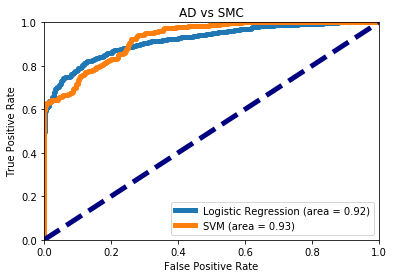

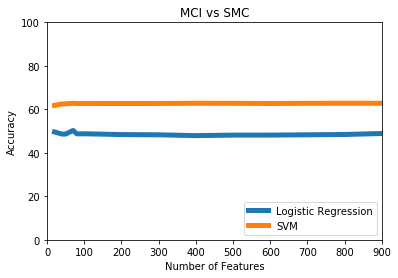

(208, 959)
[  3   4  11  12  13  14  15  16  17  18  19  20  21  22  23  24  25  26
  27  28  29  30  31  32  33  34  35  36  37  38  39  40  41  42  43  44
  45  46  47  48  49  50  51  52  53  54  55  56  57  58  59  60  61  62
  63  64  65  66  67  68  69  70  71  72  73  74  75  76  77  78  79  80
  81  82  83  84  85  86  87  88  89  90  91  92  93  94  95  96  97  98
  99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116
 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134
 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152
 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170
 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188
 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206
 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224
 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242
 243 244 245 246 247 248 249 250 251 252

/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:2247: RuntimeWarning: invalid value encountered in true_divide
  return (a - mns) / sstd


../Fig/MorADonly vs SMC.pdf


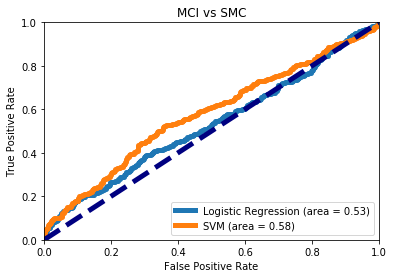

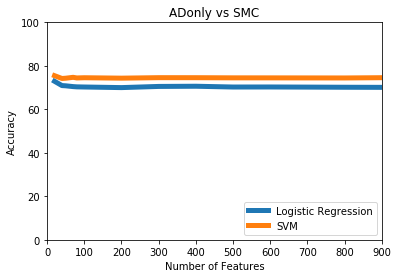

(208, 959)
[  3   4  11  12  13  14  15  16  17  18  19  20  21  22  23  24  25  26
  27  28  29  30  31  32  33  34  35  36  37  38  39  40  41  42  43  44
  45  46  47  48  49  50  51  52  53  54  55  56  57  58  59  60  61  62
  63  64  65  66  67  68  69  70  71  72  73  74  75  76  77  78  79  80
  81  82  83  84  85  86  87  88  89  90  91  92  93  94  95  96  97  98
  99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116
 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134
 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152
 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170
 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188
 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206
 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224
 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242
 243 244 245 246 247 248 249 250 251 252

/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:2247: RuntimeWarning: invalid value encountered in true_divide
  return (a - mns) / sstd


../Fig/MorAD vs MCI.pdf


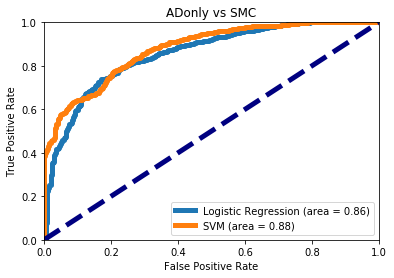

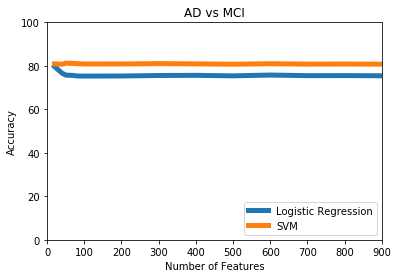

(208, 959)
[  3   4  11  12  13  14  15  16  17  18  19  20  21  22  23  24  25  26
  27  28  29  30  31  32  33  34  35  36  37  38  39  40  41  42  43  44
  45  46  47  48  49  50  51  52  53  54  55  56  57  58  59  60  61  62
  63  64  65  66  67  68  69  70  71  72  73  74  75  76  77  78  79  80
  81  82  83  84  85  86  87  88  89  90  91  92  93  94  95  96  97  98
  99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116
 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134
 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152
 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170
 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188
 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206
 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224
 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242
 243 244 245 246 247 248 249 250 251 252

/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:2247: RuntimeWarning: invalid value encountered in true_divide
  return (a - mns) / sstd


../Fig/MorADonly vs MCI.pdf


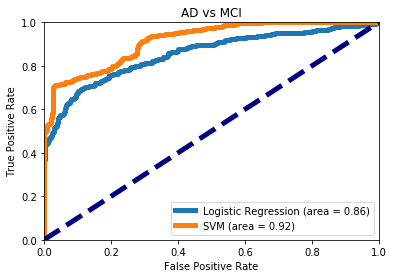

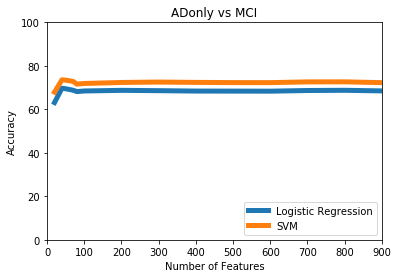

(208, 959)
[  3   4  11  12  13  14  15  16  17  18  19  20  21  22  23  24  25  26
  27  28  29  30  31  32  33  34  35  36  37  38  39  40  41  42  43  44
  45  46  47  48  49  50  51  52  53  54  55  56  57  58  59  60  61  62
  63  64  65  66  67  68  69  70  71  72  73  74  75  76  77  78  79  80
  81  82  83  84  85  86  87  88  89  90  91  92  93  94  95  96  97  98
  99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116
 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134
 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152
 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170
 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188
 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206
 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224
 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242
 243 244 245 246 247 248 249 250 251 252

/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:2247: RuntimeWarning: invalid value encountered in true_divide
  return (a - mns) / sstd


../Fig/MorADonly vs ADwithsmallvv.pdf


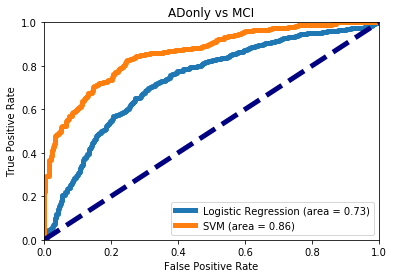

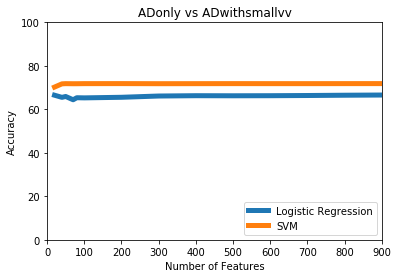

In [22]:
cwd=os.getcwd()
os.chdir('../braindata')
filename="data_1_mor.csv"
#n_features = [10,30,50,70,80,100,1000,2000,13000,18000,10000,20000,3000,30000,4000,500,5000,6000,7000,8000,9000,15000,25000]

n_features = [20,40,50,70,80,100,200,300,400,500,600,700,800,900]
save_name=["AD vs SMC","MCI vs SMC","ADonly vs SMC","AD vs MCI","ADonly vs MCI","ADonly vs ADwithsmallvv"]


for i in range(6,11):

    X,y=data_fetch_clean(filename,i)
    
    #5: ad-smi / 6:mci-smi / 7:adonly-smi / 8:ad-mci / 9:adonly-mci / 10:adonly - adwithsmallvv
    name=save_name[i-5]
    svm_para=svc_param_selection(X,y,10)
    lr_para=lr_param_selection(X,y,10)
    
    
    # this is the main function 
    lrcc,svmcc=main(X,y,svm_para,lr_para,10,10,name,n_features) # 10 fold, repeat number, and the name to save; 
    accuracy_roc_save(X,y,lrcc,svmcc,name,10,10)
    

In [7]:
from sklearn.model_selection import GridSearchCV

cwd=os.getcwd()
os.chdir('../braindata')
filename="data_3_all.csv"
X,y=data_fetch_clean(filename,6)

param_grid = [
        {'kernel': ['linear'], 'C': [0.001,0.01,0.1,1,10., 30., 100., 300., 1000., 3000., 10000., 30000.0]},
        {'kernel': ['rbf'], 'C': [1.0, 3.0, 10., 30., 100., 300., 1000.0],
         'gamma': [0.01, 0.03, 0.1, 0.3, 1.0, 3.0]},
    ]

svm_reg = svm.SVC()
grid_search = GridSearchCV(svm_reg, param_grid, cv=10, scoring='neg_mean_squared_error', verbose=2, n_jobs=4)
grid_search.fit(X,y)
negative_mse = grid_search.best_score_
rmse = np.sqrt(-negative_mse)
rmse
grid_search.best_params_

(208, 34657)
[    3     4    11 ..., 34654 34655 34656]


/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:2247: RuntimeWarning: invalid value encountered in true_divide
  return (a - mns) / sstd


Fitting 10 folds for each of 54 candidates, totalling 540 fits
[CV] C=0.001, kernel=linear ..........................................
[CV] C=0.001, kernel=linear ..........................................
[CV] C=0.001, kernel=linear ..........................................
[CV] C=0.001, kernel=linear ..........................................
[CV] ........................... C=0.001, kernel=linear, total=   0.6s
[CV] ........................... C=0.001, kernel=linear, total=   0.6s
[CV] C=0.001, kernel=linear ..........................................
[CV] C=0.001, kernel=linear ..........................................
[CV] ........................... C=0.001, kernel=linear, total=   0.6s
[CV] ........................... C=0.001, kernel=linear, total=   0.6s
[CV] C=0.001, kernel=linear ..........................................
[CV] C=0.001, kernel=linear ..........................................
[CV] ........................... C=0.001, kernel=linear, total=   0.6s
[CV] C=0.001, 

[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    9.4s


[CV] ............................... C=1, kernel=linear, total=   0.6s
[CV] C=10.0, kernel=linear ...........................................
[CV] ............................... C=1, kernel=linear, total=   0.6s
[CV] C=10.0, kernel=linear ...........................................
[CV] ............................... C=1, kernel=linear, total=   0.6s
[CV] ............................... C=1, kernel=linear, total=   0.6s
[CV] C=10.0, kernel=linear ...........................................
[CV] C=10.0, kernel=linear ...........................................
[CV] ............................ C=10.0, kernel=linear, total=   0.6s
[CV] ............................ C=10.0, kernel=linear, total=   0.6s
[CV] C=10.0, kernel=linear ...........................................
[CV] C=10.0, kernel=linear ...........................................
[CV] ............................ C=10.0, kernel=linear, total=   0.6s
[CV] ............................ C=10.0, kernel=linear, total=   0.6s
[CV] C

[CV] .......................... C=3000.0, kernel=linear, total=   0.6s
[CV] C=3000.0, kernel=linear .........................................
[CV] .......................... C=3000.0, kernel=linear, total=   0.6s
[CV] C=3000.0, kernel=linear .........................................
[CV] .......................... C=3000.0, kernel=linear, total=   0.6s
[CV] .......................... C=3000.0, kernel=linear, total=   0.6s
[CV] .......................... C=3000.0, kernel=linear, total=   0.6s
[CV] C=10000.0, kernel=linear ........................................
[CV] C=10000.0, kernel=linear ........................................
[CV] C=10000.0, kernel=linear ........................................
[CV] .......................... C=3000.0, kernel=linear, total=   0.6s
[CV] C=10000.0, kernel=linear ........................................
[CV] ......................... C=10000.0, kernel=linear, total=   0.6s
[CV] ......................... C=10000.0, kernel=linear, total=   0.6s
[CV] C

[CV] ..................... C=1.0, gamma=0.3, kernel=rbf, total=   0.6s
[CV] ..................... C=1.0, gamma=0.3, kernel=rbf, total=   0.6s
[CV] ..................... C=1.0, gamma=0.3, kernel=rbf, total=   0.6s
[CV] C=1.0, gamma=0.3, kernel=rbf ....................................
[CV] C=1.0, gamma=0.3, kernel=rbf ....................................
[CV] C=1.0, gamma=0.3, kernel=rbf ....................................
[CV] ..................... C=1.0, gamma=0.3, kernel=rbf, total=   0.6s
[CV] C=1.0, gamma=0.3, kernel=rbf ....................................


[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:   40.7s


[CV] ..................... C=1.0, gamma=0.3, kernel=rbf, total=   0.6s
[CV] ..................... C=1.0, gamma=0.3, kernel=rbf, total=   0.6s
[CV] ..................... C=1.0, gamma=0.3, kernel=rbf, total=   0.6s
[CV] C=1.0, gamma=1.0, kernel=rbf ....................................
[CV] C=1.0, gamma=1.0, kernel=rbf ....................................
[CV] C=1.0, gamma=1.0, kernel=rbf ....................................
[CV] ..................... C=1.0, gamma=0.3, kernel=rbf, total=   0.6s
[CV] C=1.0, gamma=1.0, kernel=rbf ....................................
[CV] ..................... C=1.0, gamma=1.0, kernel=rbf, total=   0.6s
[CV] C=1.0, gamma=1.0, kernel=rbf ....................................
[CV] ..................... C=1.0, gamma=1.0, kernel=rbf, total=   0.6s
[CV] C=1.0, gamma=1.0, kernel=rbf ....................................
[CV] ..................... C=1.0, gamma=1.0, kernel=rbf, total=   0.7s
[CV] C=1.0, gamma=1.0, kernel=rbf ....................................
[CV] .

[CV] ..................... C=3.0, gamma=0.3, kernel=rbf, total=   0.8s
[CV] C=3.0, gamma=0.3, kernel=rbf ....................................
[CV] ..................... C=3.0, gamma=0.3, kernel=rbf, total=   0.7s
[CV] C=3.0, gamma=0.3, kernel=rbf ....................................
[CV] ..................... C=3.0, gamma=0.3, kernel=rbf, total=   0.6s
[CV] ..................... C=3.0, gamma=0.3, kernel=rbf, total=   0.6s
[CV] C=3.0, gamma=1.0, kernel=rbf ....................................
[CV] C=3.0, gamma=1.0, kernel=rbf ....................................
[CV] ..................... C=3.0, gamma=0.3, kernel=rbf, total=   0.6s
[CV] C=3.0, gamma=1.0, kernel=rbf ....................................
[CV] ..................... C=3.0, gamma=0.3, kernel=rbf, total=   0.6s
[CV] C=3.0, gamma=1.0, kernel=rbf ....................................
[CV] ..................... C=3.0, gamma=1.0, kernel=rbf, total=   0.6s
[CV] C=3.0, gamma=1.0, kernel=rbf ....................................
[CV] .

[CV] .................... C=10.0, gamma=0.3, kernel=rbf, total=   0.6s
[CV] C=10.0, gamma=0.3, kernel=rbf ...................................
[CV] .................... C=10.0, gamma=0.3, kernel=rbf, total=   0.6s
[CV] C=10.0, gamma=0.3, kernel=rbf ...................................
[CV] .................... C=10.0, gamma=0.3, kernel=rbf, total=   0.6s
[CV] C=10.0, gamma=0.3, kernel=rbf ...................................
[CV] .................... C=10.0, gamma=0.3, kernel=rbf, total=   0.6s
[CV] C=10.0, gamma=0.3, kernel=rbf ...................................
[CV] .................... C=10.0, gamma=0.3, kernel=rbf, total=   0.6s
[CV] C=10.0, gamma=1.0, kernel=rbf ...................................
[CV] .................... C=10.0, gamma=0.3, kernel=rbf, total=   0.6s
[CV] C=10.0, gamma=1.0, kernel=rbf ...................................
[CV] .................... C=10.0, gamma=0.3, kernel=rbf, total=   0.6s
[CV] C=10.0, gamma=1.0, kernel=rbf ...................................
[CV] .

[CV] .................... C=30.0, gamma=0.3, kernel=rbf, total=   0.6s
[CV] C=30.0, gamma=0.3, kernel=rbf ...................................
[CV] .................... C=30.0, gamma=0.3, kernel=rbf, total=   0.6s
[CV] C=30.0, gamma=0.3, kernel=rbf ...................................
[CV] .................... C=30.0, gamma=0.3, kernel=rbf, total=   0.6s
[CV] C=30.0, gamma=0.3, kernel=rbf ...................................
[CV] .................... C=30.0, gamma=0.3, kernel=rbf, total=   0.6s
[CV] C=30.0, gamma=0.3, kernel=rbf ...................................
[CV] .................... C=30.0, gamma=0.3, kernel=rbf, total=   0.6s
[CV] C=30.0, gamma=0.3, kernel=rbf ...................................
[CV] .................... C=30.0, gamma=0.3, kernel=rbf, total=   0.6s
[CV] C=30.0, gamma=0.3, kernel=rbf ...................................
[CV] .................... C=30.0, gamma=0.3, kernel=rbf, total=   0.7s
[CV] C=30.0, gamma=1.0, kernel=rbf ...................................
[CV] .

[Parallel(n_jobs=4)]: Done 357 tasks      | elapsed:  1.6min


[CV] .................... C=30.0, gamma=3.0, kernel=rbf, total=   0.6s
[CV] .................... C=30.0, gamma=3.0, kernel=rbf, total=   0.6s
[CV] C=100.0, gamma=0.01, kernel=rbf .................................
[CV] C=100.0, gamma=0.01, kernel=rbf .................................
[CV] .................. C=100.0, gamma=0.01, kernel=rbf, total=   0.6s
[CV] C=100.0, gamma=0.01, kernel=rbf .................................
[CV] .................. C=100.0, gamma=0.01, kernel=rbf, total=   0.6s
[CV] C=100.0, gamma=0.01, kernel=rbf .................................
[CV] .................. C=100.0, gamma=0.01, kernel=rbf, total=   0.6s
[CV] .................. C=100.0, gamma=0.01, kernel=rbf, total=   0.6s
[CV] C=100.0, gamma=0.01, kernel=rbf .................................
[CV] C=100.0, gamma=0.01, kernel=rbf .................................
[CV] .................. C=100.0, gamma=0.01, kernel=rbf, total=   0.6s
[CV] C=100.0, gamma=0.01, kernel=rbf .................................
[CV] .

[CV] ................... C=100.0, gamma=3.0, kernel=rbf, total=   0.6s
[CV] ................... C=100.0, gamma=3.0, kernel=rbf, total=   0.6s
[CV] C=300.0, gamma=0.01, kernel=rbf .................................
[CV] C=300.0, gamma=0.01, kernel=rbf .................................
[CV] ................... C=100.0, gamma=3.0, kernel=rbf, total=   0.6s
[CV] ................... C=100.0, gamma=3.0, kernel=rbf, total=   0.6s
[CV] C=300.0, gamma=0.01, kernel=rbf .................................
[CV] C=300.0, gamma=0.01, kernel=rbf .................................
[CV] .................. C=300.0, gamma=0.01, kernel=rbf, total=   0.6s
[CV] .................. C=300.0, gamma=0.01, kernel=rbf, total=   0.6s
[CV] C=300.0, gamma=0.01, kernel=rbf .................................
[CV] C=300.0, gamma=0.01, kernel=rbf .................................
[CV] .................. C=300.0, gamma=0.01, kernel=rbf, total=   0.6s
[CV] .................. C=300.0, gamma=0.01, kernel=rbf, total=   0.6s
[CV] C

[CV] ................... C=300.0, gamma=3.0, kernel=rbf, total=   0.6s
[CV] C=300.0, gamma=3.0, kernel=rbf ..................................
[CV] ................... C=300.0, gamma=3.0, kernel=rbf, total=   0.6s
[CV] C=300.0, gamma=3.0, kernel=rbf ..................................
[CV] ................... C=300.0, gamma=3.0, kernel=rbf, total=   0.6s
[CV] ................... C=300.0, gamma=3.0, kernel=rbf, total=   0.6s
[CV] C=1000.0, gamma=0.01, kernel=rbf ................................
[CV] C=1000.0, gamma=0.01, kernel=rbf ................................
[CV] ................... C=300.0, gamma=3.0, kernel=rbf, total=   0.6s
[CV] C=1000.0, gamma=0.01, kernel=rbf ................................
[CV] ................... C=300.0, gamma=3.0, kernel=rbf, total=   0.6s
[CV] C=1000.0, gamma=0.01, kernel=rbf ................................
[CV] ................. C=1000.0, gamma=0.01, kernel=rbf, total=   0.6s
[CV] ................. C=1000.0, gamma=0.01, kernel=rbf, total=   0.6s
[CV] C

[CV] .................. C=1000.0, gamma=3.0, kernel=rbf, total=   0.6s
[CV] .................. C=1000.0, gamma=3.0, kernel=rbf, total=   0.6s
[CV] C=1000.0, gamma=3.0, kernel=rbf .................................
[CV] C=1000.0, gamma=3.0, kernel=rbf .................................
[CV] .................. C=1000.0, gamma=3.0, kernel=rbf, total=   0.6s
[CV] C=1000.0, gamma=3.0, kernel=rbf .................................
[CV] .................. C=1000.0, gamma=3.0, kernel=rbf, total=   0.6s
[CV] C=1000.0, gamma=3.0, kernel=rbf .................................
[CV] .................. C=1000.0, gamma=3.0, kernel=rbf, total=   0.6s
[CV] .................. C=1000.0, gamma=3.0, kernel=rbf, total=   0.6s
[CV] .................. C=1000.0, gamma=3.0, kernel=rbf, total=   0.6s
[CV] .................. C=1000.0, gamma=3.0, kernel=rbf, total=   0.6s


[Parallel(n_jobs=4)]: Done 540 out of 540 | elapsed:  2.4min finished


{'C': 0.001, 'kernel': 'linear'}